In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

target = 'is_fraud'

# Separate features and target
X = train.drop(columns=[target])
y = train[target]

print(train.head())
print(train.info())

# Check target variable distribution
print(train['is_fraud'].value_counts(normalize=True))

# Keep 'id' for test set
test_ids = test['id']

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop                          job  \
0  ...  62220  38.5127  -89.9847    

In [ ]:
from sklearn.impute import SimpleImputer


def preprocess_data(df, drop_cols):
    # Process datetime features
    if 'trans_date' in df.columns and 'trans_time' in df.columns:
        df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])
        df['hour'] = df['trans_datetime'].dt.hour
        df['day_of_week'] = df['trans_datetime'].dt.dayofweek
        df['day'] = df['trans_datetime'].dt.day
        df.drop(['trans_datetime', 'trans_date', 'trans_time'], axis=1, inplace=True, errors='ignore')

    # Drop unnecessary columns
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True, errors='ignore')

    # Separate numerical and categorical columns
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()

    # Handle missing values in numerical columns
    if len(num_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        df[num_cols] = pd.DataFrame(num_imputer.fit_transform(df[num_cols]), 
                                    columns=num_cols, 
                                    index=df.index)

    # Handle missing values in categorical columns
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(df[cat_cols]), 
                                    columns=cat_cols, 
                                    index=df.index)

    # Final fallback: fill any remaining NaN values
    df.fillna(-999, inplace=True)

    return df


# List of columns to drop
drop_cols = ['id', 'trans_num', 'unix_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 
             'zip', 'job', 'dob', 'merchant', 'lat', 'long', 'merch_lat', 'merch_long']

# Preprocess training and test sets
X = preprocess_data(X, drop_cols)

test = preprocess_data(test, drop_cols)


# Handle categorical features consistently
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X[col], test[col]], axis=0).astype(str)  # Combine for consistent encoding
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))


def process_datetime_features(df):
    # If trans_date and trans_time are given as strings
    # Combine them into a single datetime column if needed
    if 'trans_date' in df.columns and 'trans_time' in df.columns:
        df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])
        df['hour'] = df['trans_datetime'].dt.hour
        df['day_of_week'] = df['trans_datetime'].dt.dayofweek
        df['day'] = df['trans_datetime'].dt.day
        df.drop(['trans_datetime','trans_date','trans_time'], axis=1, inplace=True, errors='ignore')
    return df

X = process_datetime_features(X)
test = process_datetime_features(test)

# 2. Drop columns that may not be predictive or are unique identifiers
drop_cols = ['id', 'trans_num', 'unix_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 
             'merchant', 'lat', 'long', 'merch_lat', 'merch_long']
for col in drop_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)
    if col in test.columns:
        test.drop(col, axis=1, inplace=True)

# 3. Handle categorical features
# Identify categorical columns (object type)
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [25]:
def feature_engineering(df):
    # Log-transform transaction amount
    df['amt_log'] = np.log1p(df['amt'].clip(lower=0))

    # Bin transaction amounts
    df['amt_bin'] = pd.cut(df['amt'], bins=[0, 50, 100, 500, 1000, 5000], labels=False)

    # Interaction between hour and category
    df['hour_category'] = df['hour'].astype(str) + '_' + df['category'].astype(str)

    # Peak hour flag
    df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 8 <= x <= 20 else 0)

    # Outlier flag for high transaction amounts
    df['is_high_amt'] = (df['amt'] > 5000).astype(int)

    return df

# Apply feature engineering
X = feature_engineering(X)
test = feature_engineering(test)

# Groupby for fraud-related and rare value features
user_stats = X.groupby('cc_num').agg(
    user_fraud_count=('is_fraud', 'sum'),
    avg_amt_user=('amt', 'mean')
).reset_index()

merchant_stats = X.groupby('merchant').agg(
    merchant_fraud_rate=('is_fraud', 'mean'),
    transaction_count=('merchant', 'size')
).reset_index()

# Merge stats into both train and test
X = X.merge(user_stats, on='cc_num', how='left')
X = X.merge(merchant_stats, on='merchant', how='left')
test = test.merge(user_stats, on='cc_num', how='left')
test = test.merge(merchant_stats, on='merchant', how='left')

# Fill missing values
X.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

# Handle categorical features
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))



KeyError: 'cc_num'

In [9]:
total_nans = X.isnull().sum().sum()
print(f"Total number of NaN values: {total_nans}")


Total number of NaN values: 43


In [10]:
from imblearn.over_sampling import SMOTE

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
# sm = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid with reduced ranges
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
}

# Randomized Search with fewer iterations and 3-fold CV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,  # Fewer iterations for speed
    scoring='f1',
    cv=3,  
    verbose=1,
    n_jobs=-1,  # Use all cores
    random_state=42
)

# Fit the RandomizedSearchCV on a smaller subset (optional)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)
random_search.fit(X_sample, y_sample)
# random_search.fit(X_train_resampled, y_train_resampled)


# Get the best model
best_rf_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Validate the model
val_preds = best_rf_model.predict(X_val)
print("Validation F1 Score:", f1_score(y_val, val_preds))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
Validation F1 Score: 0.9150788336275644


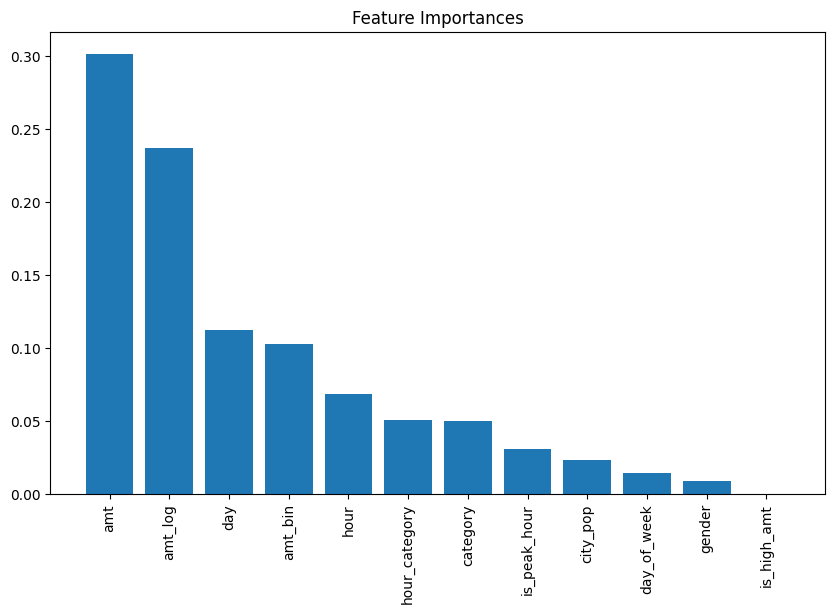

In [15]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

# Plot top features
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices])
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importances")
plt.show()


test_preds = best_rf_model.predict(test)


In [16]:
# Validate the model on the validation set
val_preds = best_rf_model.predict(X_val)
val_f1 = f1_score(y_val, val_preds)
print(f"Validation F1 Score: {val_f1:.4f}")

# Predict on the test set
test_preds = best_rf_model.predict(test)

Validation F1 Score: 0.9151


Confusion Matrix:
 [[65230   451]
 [  944  7516]]


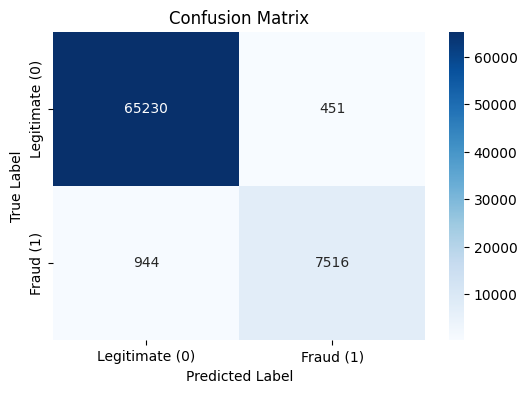

In [17]:
from sklearn.metrics import f1_score, confusion_matrix
# Confusion Matrix
cm = confusion_matrix(y_val, val_preds)
print("Confusion Matrix:\n", cm)

# Optional: Display confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate (0)', 'Fraud (1)'],
            yticklabels=['Legitimate (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
submission = pd.DataFrame({'id': test_ids, 'is_fraud': test_preds})
submission.to_csv('my_submission.csv', index=False)
print("Submission file created: my_submission.csv")

Submission file created: my_submission.csv
